In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import src.data.ToyData as ToyData
import src.models as models
import src.Trainer as Trainer
import src.SDESolver as SDESolver
import src.SDE as SDE
from src.plot import plot_trajectory_2d, plot_matrix, plot_score_field
import matplotlib.pyplot as plt
import random 
import experiments.ssm_config as ssm_config

def get_random_int():
    return random.randint(0, 1000000)


In [2]:


# data_generator = ToyData.CircleDataGenerator(landmark_num=32, radius=0.5, center=jnp.array([0, 0]), seed=4523663)
# trainer = Trainer.SsmTrainer(seed=445632)
# model = models.DsmModel(dim=2, hidden_dims=(128,256, 512, 256,128), with_x0=True)

# x_0 = data_generator.generate_data(jrandom.PRNGKey(0), 64)
# brownian_sde = SDE.Brownian_Motion_SDE(dim=2, sigma=0.1, x0=x_0[0])
# kunita_lagrange_sde = SDE.Kunita_Lagrange_SDE(sigma=0.1, kappa=0.3, x0=x_0[0])
# kunita_eulerian_sde = SDE.Kunita_Eulerian_SDE(sigma=0.5, kappa=0.06, grid_dim=2, grid_num=32, grid_range=(-1.5,1.5), x0=x_0[0])
# sde_solver = SDESolver.EulerMaruyama.from_sde(brownian_sde, 0.01, 1, 2, jrandom.PRNGKey(1),debug_mode=True)
# xs, diffusions = jax.vmap(sde_solver.solve, in_axes=(0, None))(x_0, jrandom.PRNGKey(5))


# plot_trajectory_2d(xs[0], "Brownian SDE", simplified=False)
# plot_matrix(diffusions[0, 0] @ diffusions[0, 0].T, "Brownian SDE diffusion matrix t=0")
# plot_matrix(diffusions[0,49] @ diffusions[0,49].T, "Brownian SDE diffusion matrix t=0.5")
# plot_matrix(diffusions[0, -1] @ diffusions[0, -1].T, "Brownian SDE diffusion matrix t=1")

# plt.show()


In [3]:

# train_state = trainer.train_state_init(model, lr=1e-4, model_kwargs={'x': x_0[0], 't': jnp.array([0]), 'x0': x_0[0]})
# train_state, losses = trainer.train(train_state, brownian_sde, sde_solver, data_generator, 1000, 64)
# plt.plot(losses)
# plt.show()




In [4]:
# from src.plot import plot_score_field

# score_fn = lambda x, t, x0: train_state.apply_fn(train_state.params, x, t, x0=x0)
# data_generator = ToyData.CircleDataGenerator(landmark_num=32, radius=1, center=jnp.array([0, 0]), seed=486435)
# xt = data_generator.generate_data(jrandom.PRNGKey(6), 1)
# print(xt.shape)
# print(x_0[0].shape)
# reversed_sde = SDE.Time_Reversed_SDE(brownian_sde, score_fn, 1, 0.01)
# reversed_sde_solver = SDESolver.EulerMaruyama.from_sde(reversed_sde, 0.01, 1, 2, jrandom.PRNGKey(8), condition_x=x_0[0],debug_mode=True)
# xs, _ = reversed_sde_solver.solve(xt[0], jrandom.PRNGKey(156))
# plot_trajectory_2d(xs, "Reversed Brownian SDE", simplified=False)
# # plot_score_field(score_fn, 1, x_0[0])
# # plot_score_field(score_fn, 0.5, x_0[0])
# # plot_score_field(score_fn, 0, x_0[0])


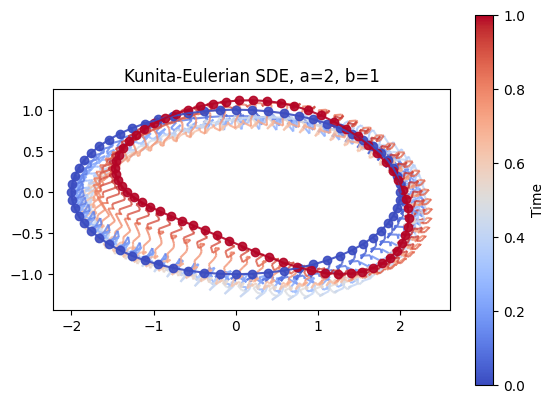

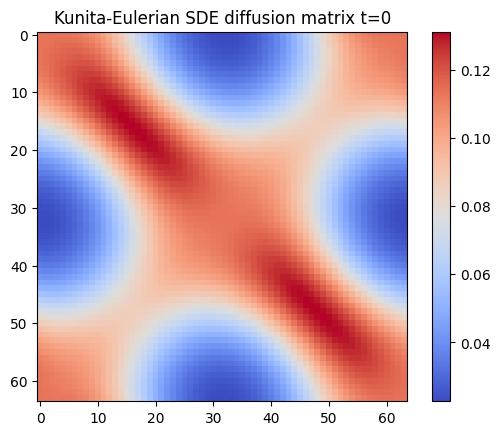

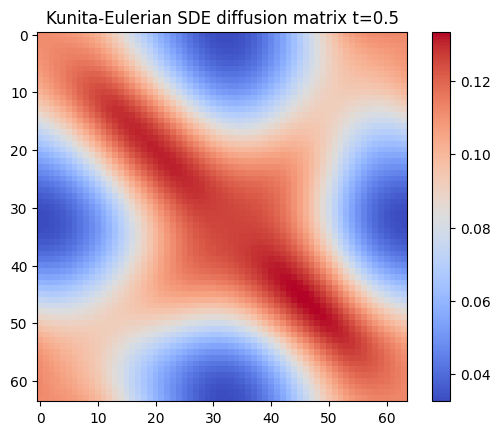

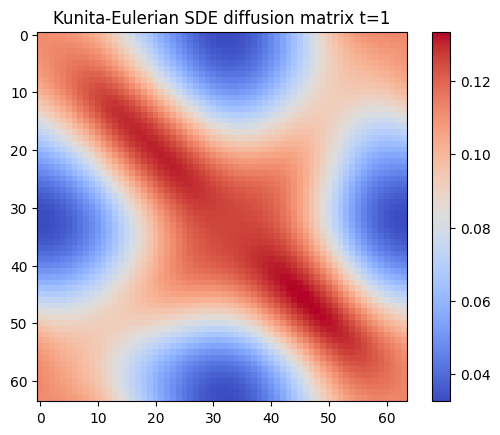

Bar desc:   0%|          | 0/3000 [00:00<?, ?it/s]

(51,)
(50, 8)


Training loss: 99.85553741455078: 100%|██████████| 3000/3000 [02:14<00:00, 22.36it/s] 


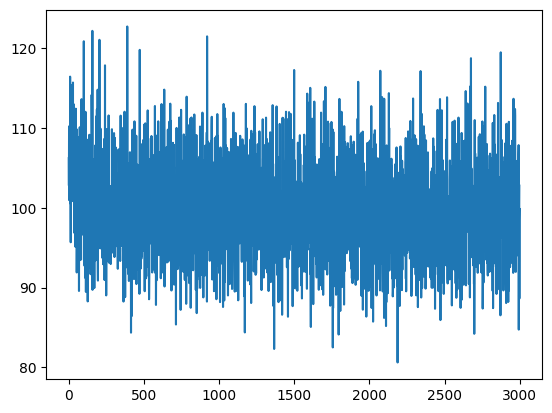

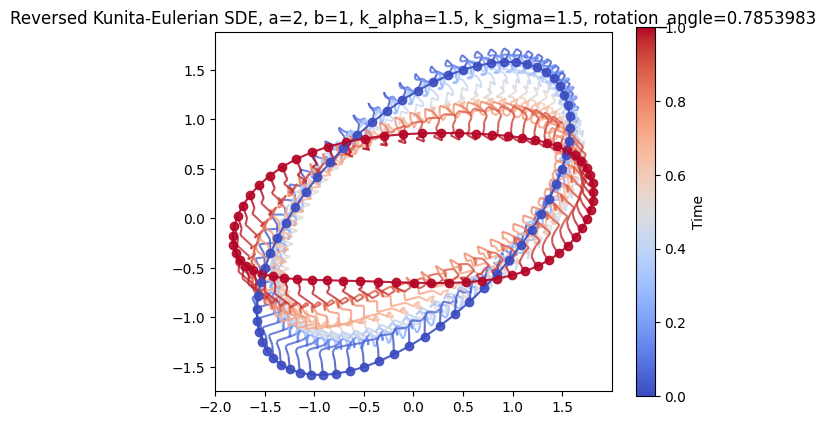

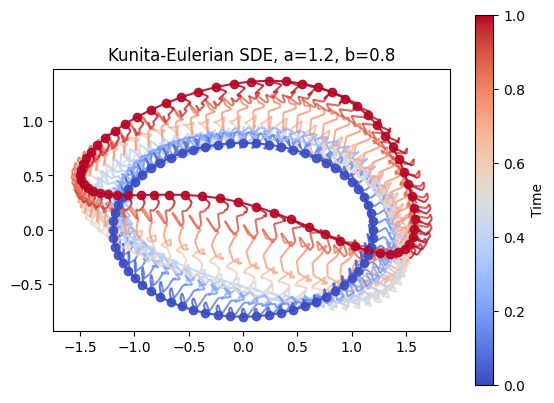

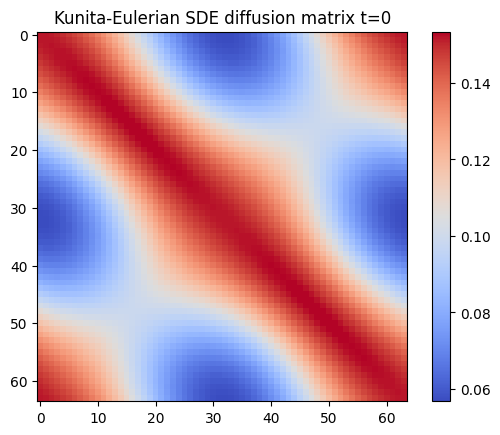

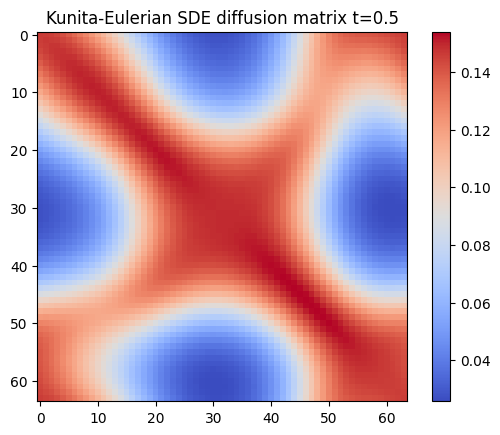

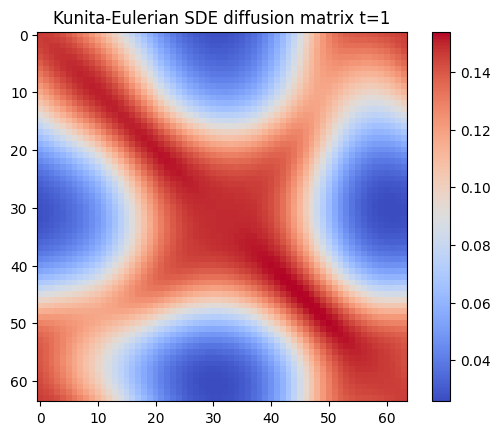

Bar desc:   0%|          | 0/3000 [00:00<?, ?it/s]

(51,)
(50, 8)


Training loss: 97.45661926269531: 100%|██████████| 3000/3000 [02:19<00:00, 21.44it/s] 


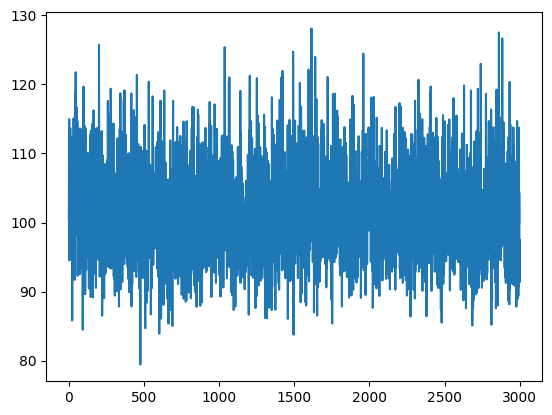

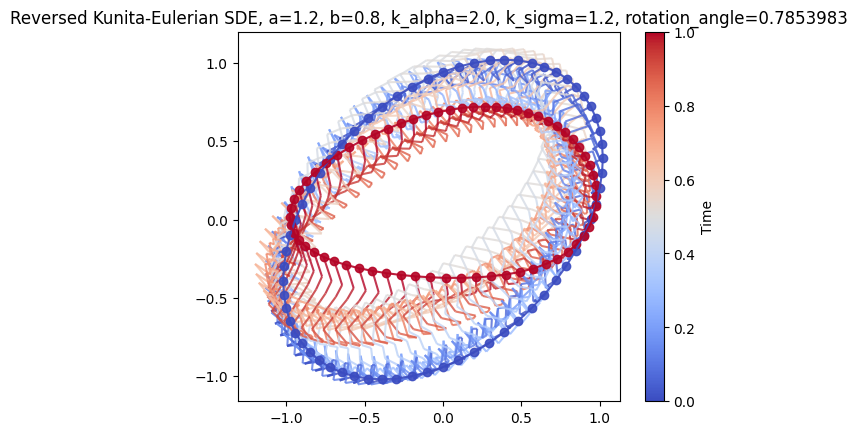

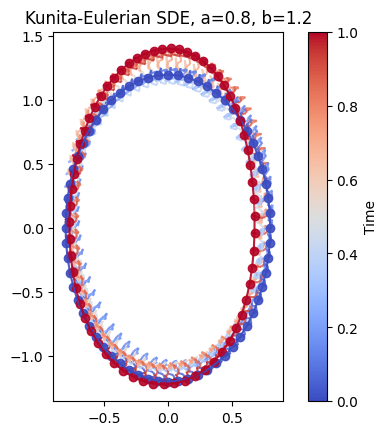

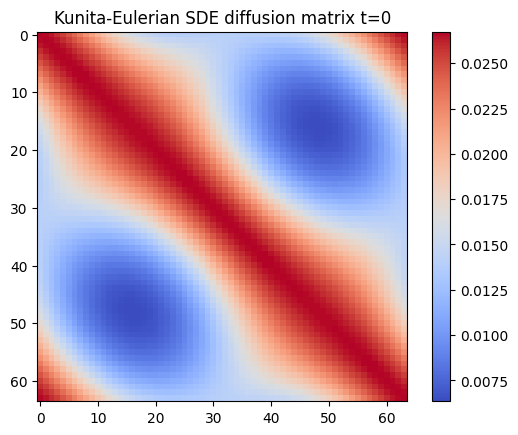

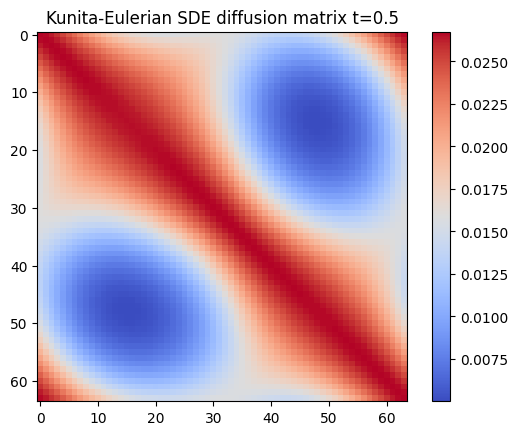

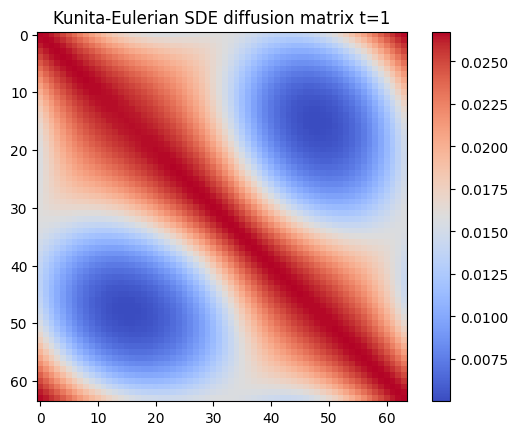

Bar desc:   0%|          | 0/3000 [00:00<?, ?it/s]

(51,)
(50, 8)


Training loss: 58.70725631713867: 100%|██████████| 3000/3000 [02:22<00:00, 21.08it/s] 


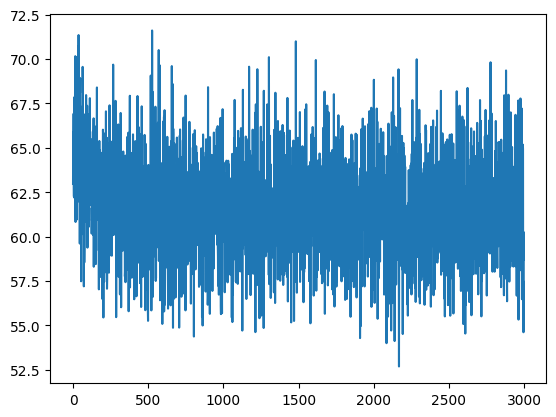

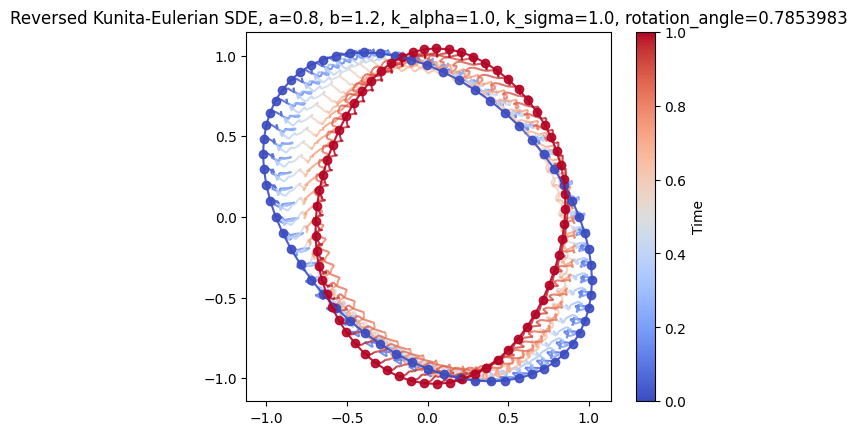

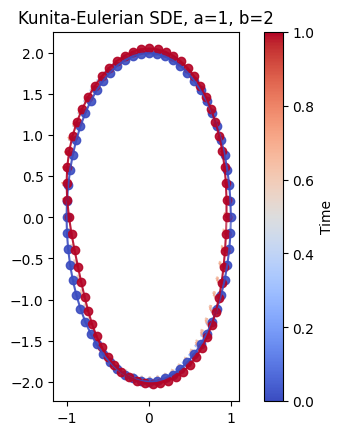

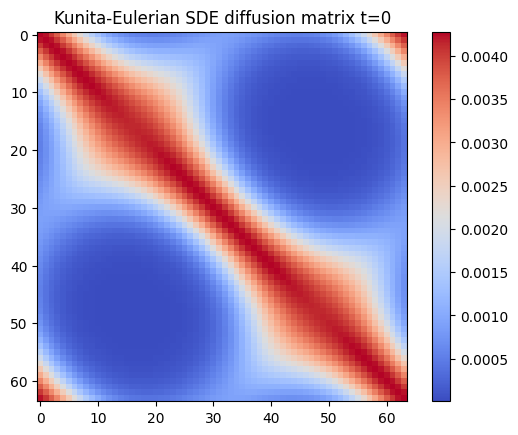

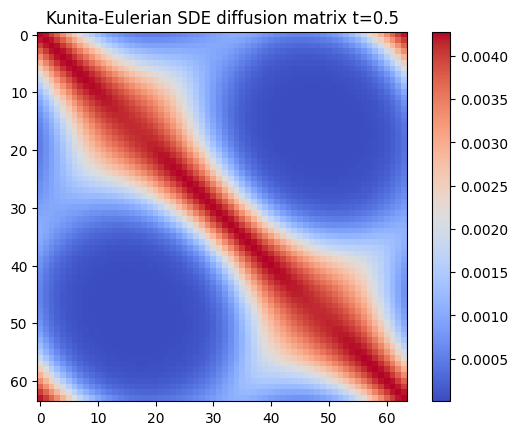

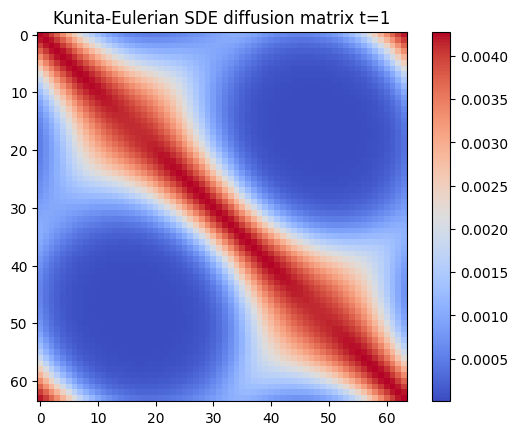

Bar desc:   0%|          | 0/3000 [00:00<?, ?it/s]

(51,)
(50, 8)


Training loss: 79.81902313232422: 100%|██████████| 3000/3000 [02:26<00:00, 20.54it/s]


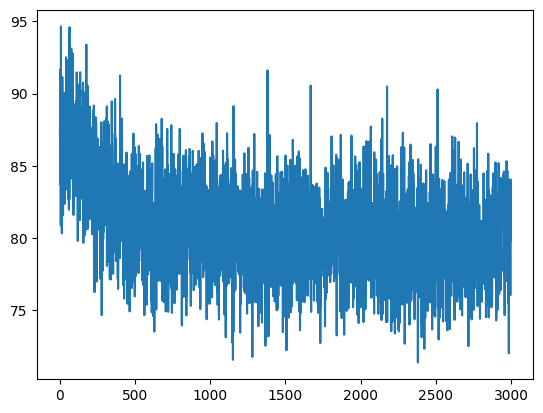

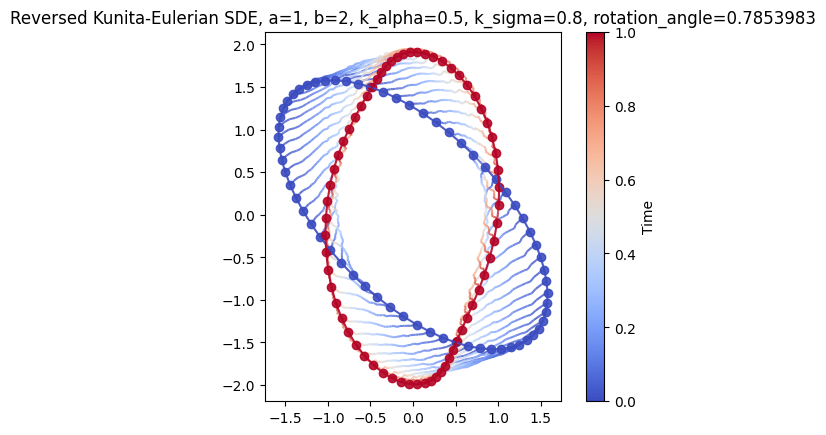

In [5]:
# example 2: learning the score function of a Kunita-Eulerian SDE
# circle_data_generator = ToyData.CircleDataGenerator(landmark_num=32, radius=0.5, center=jnp.array([0, 0]), seed=165)
import src.math.geometry as geometry
import src.data.ToyData as ToyData
import jax.lax as lax
rotation_matrix_1 = ssm_config.data_generator_configs['data_generator_params']['rotation_matrix'][0]
rotation_matrix_2 = ssm_config.data_generator_configs['data_generator_params']['rotation_matrix'][1]
rotation_matrix_3 = ssm_config.data_generator_configs['data_generator_params']['rotation_matrix'][2]
rotation_matrix_4 = ssm_config.data_generator_configs['data_generator_params']['rotation_matrix'][3]
a_1 = ssm_config.data_generator_configs['data_generator_params']['a'][0]
a_2 = ssm_config.data_generator_configs['data_generator_params']['a'][1]
a_3 = ssm_config.data_generator_configs['data_generator_params']['a'][2]
a_4 = ssm_config.data_generator_configs['data_generator_params']['a'][3]
b_1 = ssm_config.data_generator_configs['data_generator_params']['b'][0]
b_2 = ssm_config.data_generator_configs['data_generator_params']['b'][1]
b_3 = ssm_config.data_generator_configs['data_generator_params']['b'][2]
b_4 = ssm_config.data_generator_configs['data_generator_params']['b'][3]
rotation_matrix_1 = ssm_config.data_generator_configs['data_generator_params']['rotation_matrix'][0]
rotation_matrix_2 = ssm_config.data_generator_configs['data_generator_params']['rotation_matrix'][1]
rotation_matrix_3 = ssm_config.data_generator_configs['data_generator_params']['rotation_matrix'][2]
rotation_matrix_4 = ssm_config.data_generator_configs['data_generator_params']['rotation_matrix'][3]
center_1 = ssm_config.data_generator_configs['data_generator_params']['center'][0]
center_2 = ssm_config.data_generator_configs['data_generator_params']['center'][1]
center_3 = ssm_config.data_generator_configs['data_generator_params']['center'][2]
center_4 = ssm_config.data_generator_configs['data_generator_params']['center'][3]
k_alpha_1 = ssm_config.eulerian_sde_configs['sde_params']['k_alpha'][0]
k_alpha_2 = ssm_config.eulerian_sde_configs['sde_params']['k_alpha'][1]
k_alpha_3 = ssm_config.eulerian_sde_configs['sde_params']['k_alpha'][2]
k_alpha_4 = ssm_config.eulerian_sde_configs['sde_params']['k_alpha'][3]
k_sigma_1 = ssm_config.eulerian_sde_configs['sde_params']['k_sigma'][0]
k_sigma_2 = ssm_config.eulerian_sde_configs['sde_params']['k_sigma'][1]
k_sigma_3 = ssm_config.eulerian_sde_configs['sde_params']['k_sigma'][2]
k_sigma_4 = ssm_config.eulerian_sde_configs['sde_params']['k_sigma'][3]
grid_range = ssm_config.eulerian_sde_configs['sde_params']['grid_range']
dt = ssm_config.eulerian_sde_configs['sde_params']['dt']
grid_size = ssm_config.eulerian_sde_configs['sde_params']['grid_size']


ellipse_data_generator_1 = ToyData.EllipseDataGenerator(landmark_num=64, a=a_1, b=b_1, rotation_matrix=rotation_matrix_1, center=center_1, seed=get_random_int())
ellipse_data_generator_2 = ToyData.EllipseDataGenerator(landmark_num=64, a=a_2, b=b_2, rotation_matrix=rotation_matrix_1, center=center_2, seed=get_random_int())
ellipse_data_generator_3 = ToyData.EllipseDataGenerator(landmark_num=64, a=a_3, b=b_3, rotation_matrix=rotation_matrix_1, center=center_3, seed=get_random_int())
ellipse_data_generator_4 = ToyData.EllipseDataGenerator(landmark_num=64, a=a_4, b=b_4, rotation_matrix=rotation_matrix_1, center=center_4, seed=get_random_int())

x_0_1 = ellipse_data_generator_1.generate_data(batch_size=8)
x_0_2 = ellipse_data_generator_2.generate_data(batch_size=8)
x_0_3 = ellipse_data_generator_3.generate_data(batch_size=8)
x_0_4 = ellipse_data_generator_4.generate_data(batch_size=8)

kunita_eulerian_sde_1 = SDE.Kunita_Eulerian_SDE(sigma=k_alpha_1, kappa=k_sigma_1, grid_dim=2, grid_num=grid_size, grid_range=grid_range, x0=x_0_1[0])
kunita_eulerian_sde_2 = SDE.Kunita_Eulerian_SDE(sigma=k_alpha_2, kappa=k_sigma_2, grid_dim=2, grid_num=grid_size, grid_range=grid_range, x0=x_0_2[0])
kunita_eulerian_sde_3 = SDE.Kunita_Eulerian_SDE(sigma=k_alpha_3, kappa=k_sigma_3, grid_dim=2, grid_num=grid_size, grid_range=grid_range, x0=x_0_3[0])
kunita_eulerian_sde_4 = SDE.Kunita_Eulerian_SDE(sigma=k_alpha_4, kappa=k_sigma_4, grid_dim=2, grid_num=grid_size, grid_range=grid_range, x0=x_0_4[0])


kunita_eulerian_sde_solver_1 = SDESolver.EulerMaruyama.from_sde(kunita_eulerian_sde_1, dt, 1, 2)
kunita_eulerian_sde_solver_2 = SDESolver.EulerMaruyama.from_sde(kunita_eulerian_sde_2, dt, 1, 2)
kunita_eulerian_sde_solver_3 = SDESolver.EulerMaruyama.from_sde(kunita_eulerian_sde_3, dt, 1, 2)
kunita_eulerian_sde_solver_4 = SDESolver.EulerMaruyama.from_sde(kunita_eulerian_sde_4, dt, 1, 2)

model = models.DsmModel(dim=2, score_hidden_dims=(128, 512, 128), x_hidden_dims=(1024, 1024, 128), t_hidden_dims=(1024, 1024, 128), with_x0=True, t_embedding_dim=80)

trainer = Trainer.SsmTrainer(seed=get_random_int())


xs_1, diffusions_1 = jax.vmap(kunita_eulerian_sde_solver_1.solve, in_axes=(0, None))(x_0_1, jrandom.PRNGKey(get_random_int()))
plot_trajectory_2d(xs_1[0], "Kunita-Eulerian SDE, a="+str(a_1)+", b="+str(b_1), simplified=False)
plot_matrix(diffusions_1[0, 0] @ diffusions_1[0, 0].T, "Kunita-Eulerian SDE diffusion matrix t=0")
plot_matrix(diffusions_1[0,49] @ diffusions_1[0,49].T, "Kunita-Eulerian SDE diffusion matrix t=0.5")
plot_matrix(diffusions_1[0, -1] @ diffusions_1[0, -1].T, "Kunita-Eulerian SDE diffusion matrix t=1")
plt.show()
train_state_1 = trainer.train_state_init(model, lr=1e-4, model_kwargs={'x': jax.random.normal(jrandom.PRNGKey(get_random_int()), x_0_1[0].shape), 't': jnp.array([0]), 'x0': x_0_1[0], 'object_fn': 'Heng'})
train_state_1, losses_1 = trainer.train(train_state_1, kunita_eulerian_sde_1, kunita_eulerian_sde_solver_1, ellipse_data_generator_1, 3000, batch_size=8)
plt.plot(losses_1)
plt.show()
score_fn_1 = lambda x, t, x0: train_state_1.apply_fn(train_state_1.params, x, t, x0=x0)
ellipse_data_generator_test_1 = ToyData.EllipseDataGenerator(landmark_num=64, a=a_1, b=b_1, rotation_matrix=rotation_matrix_2, center=center_1, seed=get_random_int())
xt_1 = ellipse_data_generator_test_1.generate_data(1)
reversed_sde_1 = SDE.Time_Reversed_SDE(kunita_eulerian_sde_1, score_fn_1, 1, 0.02)
reversed_sde_solver_1 = SDESolver.EulerMaruyama.from_sde(reversed_sde_1, 0.02, 1, 2, condition_x=x_0_1[0])
xs_1, _ = reversed_sde_solver_1.solve(xt_1[0], jrandom.PRNGKey(get_random_int()))
plot_trajectory_2d(xs_1, "Reversed Kunita-Eulerian SDE, a="+str(a_1)+", b="+str(b_1)+", k_alpha="+str(k_alpha_1)+", k_sigma="+str(k_sigma_1)+", rotation_angle="+str(geometry.get_rotation_angle(rotation_matrix_2)), simplified=False)
plt.show()


xs_2, diffusions_2 = jax.vmap(kunita_eulerian_sde_solver_2.solve, in_axes=(0, None))(x_0_2, jrandom.PRNGKey(get_random_int()))
plot_trajectory_2d(xs_2[0], "Kunita-Eulerian SDE, a="+str(a_2)+", b="+str(b_2), simplified=False)
plot_matrix(diffusions_2[0, 0] @ diffusions_2[0, 0].T, "Kunita-Eulerian SDE diffusion matrix t=0")
plot_matrix(diffusions_2[0,49] @ diffusions_2[0,49].T, "Kunita-Eulerian SDE diffusion matrix t=0.5")
plot_matrix(diffusions_2[0, -1] @ diffusions_2[0, -1].T, "Kunita-Eulerian SDE diffusion matrix t=1")
plt.show()
train_state_2 = trainer.train_state_init(model, lr=1e-4, model_kwargs={'x': jax.random.normal(jrandom.PRNGKey(get_random_int()), x_0_2[0].shape), 't': jnp.array([0]), 'x0': x_0_2[0], 'object_fn': 'Heng'})
train_state_2, losses_2 = trainer.train(train_state_2, kunita_eulerian_sde_2, kunita_eulerian_sde_solver_2, ellipse_data_generator_2, 3000, batch_size=8)
plt.plot(losses_2)
plt.show()
score_fn_2 = lambda x, t, x0: train_state_2.apply_fn(train_state_2.params, x, t, x0=x0)
ellipse_data_generator_test_2 = ToyData.EllipseDataGenerator(landmark_num=64, a=a_2, b=b_2, rotation_matrix=rotation_matrix_2, center=center_2, seed=get_random_int())
xt_2 = ellipse_data_generator_test_2.generate_data(1)
reversed_sde_2 = SDE.Time_Reversed_SDE(kunita_eulerian_sde_2, score_fn_2, 1, 0.02)
reversed_sde_solver_2 = SDESolver.EulerMaruyama.from_sde(reversed_sde_2, 0.02, 1, 2, condition_x=x_0_2[0])
xs_2, _ = reversed_sde_solver_2.solve(xt_2[0], jrandom.PRNGKey(get_random_int()))
plot_trajectory_2d(xs_2, "Reversed Kunita-Eulerian SDE, a="+str(a_2)+", b="+str(b_2)+", k_alpha="+str(k_alpha_2)+", k_sigma="+str(k_sigma_2)+", rotation_angle="+str(geometry.get_rotation_angle(rotation_matrix_2)), simplified=False)
plt.show()


xs_3, diffusions_3 = jax.vmap(kunita_eulerian_sde_solver_3.solve, in_axes=(0, None))(x_0_3, jrandom.PRNGKey(get_random_int()))
plot_trajectory_2d(xs_3[0], "Kunita-Eulerian SDE, a="+str(a_3)+", b="+str(b_3), simplified=False)
plot_matrix(diffusions_3[0, 0] @ diffusions_3[0, 0].T, "Kunita-Eulerian SDE diffusion matrix t=0")
plot_matrix(diffusions_3[0,49] @ diffusions_3[0,49].T, "Kunita-Eulerian SDE diffusion matrix t=0.5")
plot_matrix(diffusions_3[0, -1] @ diffusions_3[0, -1].T, "Kunita-Eulerian SDE diffusion matrix t=1")
plt.show()
train_state_3 = trainer.train_state_init(model, lr=1e-4, model_kwargs={'x': jax.random.normal(jrandom.PRNGKey(get_random_int()), x_0_3[0].shape), 't': jnp.array([0]), 'x0': x_0_3[0], 'object_fn': 'Heng'})
train_state_3, losses_3 = trainer.train(train_state_3, kunita_eulerian_sde_3, kunita_eulerian_sde_solver_3, ellipse_data_generator_3, 3000, batch_size=8)
plt.plot(losses_3)
plt.show()
score_fn_3 = lambda x, t, x0: train_state_3.apply_fn(train_state_3.params, x, t, x0=x0)
ellipse_data_generator_test_3 = ToyData.EllipseDataGenerator(landmark_num=64, a=a_3, b=b_3, rotation_matrix=rotation_matrix_2, center=center_3, seed=get_random_int())
xt_3 = ellipse_data_generator_test_3.generate_data(1)
reversed_sde_3 = SDE.Time_Reversed_SDE(kunita_eulerian_sde_3, score_fn_3, 1, 0.02)
reversed_sde_solver_3 = SDESolver.EulerMaruyama.from_sde(reversed_sde_3, 0.02, 1, 2, condition_x=x_0_3[0])
xs_3, _ = reversed_sde_solver_3.solve(xt_3[0], jrandom.PRNGKey(get_random_int()))
plot_trajectory_2d(xs_3, "Reversed Kunita-Eulerian SDE, a="+str(a_3)+", b="+str(b_3)+", k_alpha="+str(k_alpha_3)+", k_sigma="+str(k_sigma_3)+", rotation_angle="+str(geometry.get_rotation_angle(rotation_matrix_2)), simplified=False)
plt.show()





xs_4, diffusions_4 = jax.vmap(kunita_eulerian_sde_solver_4.solve, in_axes=(0, None))(x_0_4, jrandom.PRNGKey(get_random_int()))
plot_trajectory_2d(xs_4[0], "Kunita-Eulerian SDE, a="+str(a_4)+", b="+str(b_4), simplified=False)
plot_matrix(diffusions_4[0, 0] @ diffusions_4[0, 0].T, "Kunita-Eulerian SDE diffusion matrix t=0")
plot_matrix(diffusions_4[0,49] @ diffusions_4[0,49].T, "Kunita-Eulerian SDE diffusion matrix t=0.5")
plot_matrix(diffusions_4[0, -1] @ diffusions_4[0, -1].T, "Kunita-Eulerian SDE diffusion matrix t=1")
plt.show()



train_state_4 = trainer.train_state_init(model, lr=1e-4, model_kwargs={'x': jax.random.normal(jrandom.PRNGKey(get_random_int()), x_0_4[0].shape), 't': jnp.array([0]), 'x0': x_0_4[0], 'object_fn': 'Heng'})

train_state_4, losses_4 = trainer.train(train_state_4, kunita_eulerian_sde_4, kunita_eulerian_sde_solver_4, ellipse_data_generator_4, 3000, batch_size=8)

plt.plot(losses_4)
plt.show()

score_fn_4 = lambda x, t, x0: train_state_4.apply_fn(train_state_4.params, x, t, x0=x0)

ellipse_data_generator_test_4 = ToyData.EllipseDataGenerator(landmark_num=64, a=a_4, b=b_4, rotation_matrix=rotation_matrix_2, center=center_4, seed=get_random_int())
xt_4 = ellipse_data_generator_test_4.generate_data(1)
reversed_sde_4 = SDE.Time_Reversed_SDE(kunita_eulerian_sde_4, score_fn_4, 1, 0.02)
reversed_sde_solver_4 = SDESolver.EulerMaruyama.from_sde(reversed_sde_4, 0.02, 1, 2, condition_x=x_0_4[0])
xs_4, _ = reversed_sde_solver_4.solve(xt_4[0], jrandom.PRNGKey(get_random_int()))
plot_trajectory_2d(xs_4, "Reversed Kunita-Eulerian SDE, a="+str(a_4)+", b="+str(b_4)+", k_alpha="+str(k_alpha_4)+", k_sigma="+str(k_sigma_4)+", rotation_angle="+str(geometry.get_rotation_angle(rotation_matrix_2)), simplified=False)
plt.show()



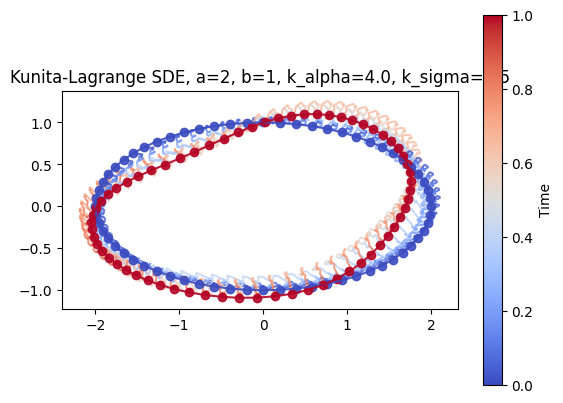

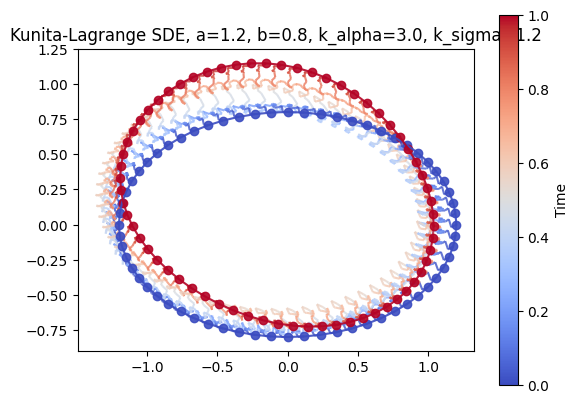

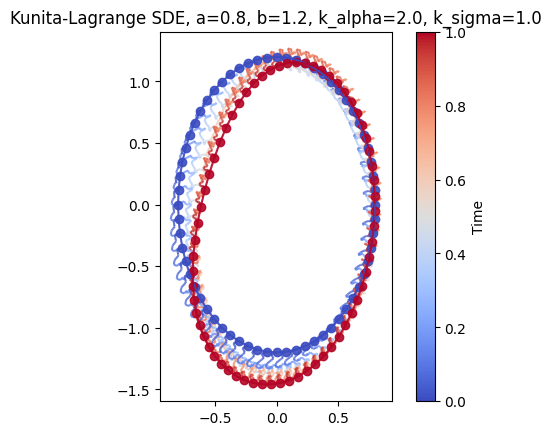

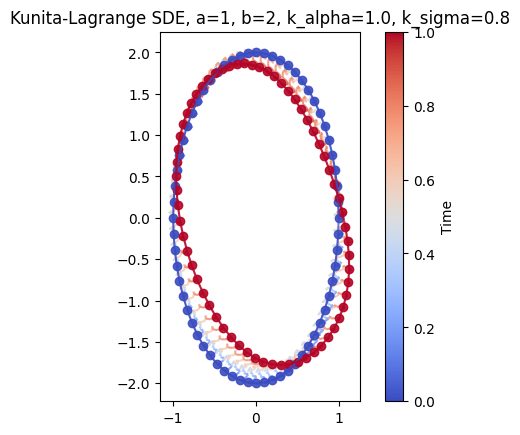

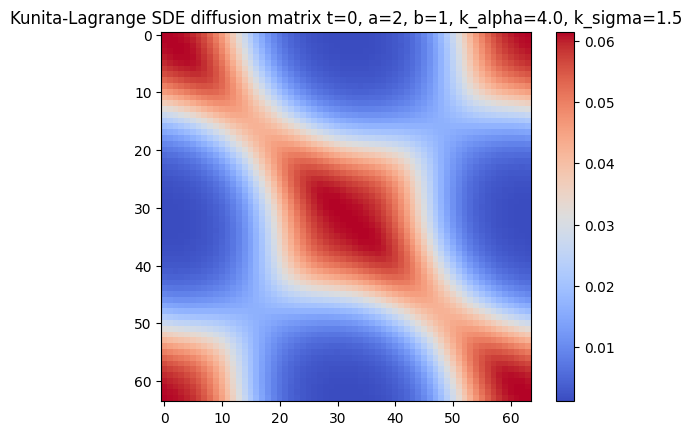

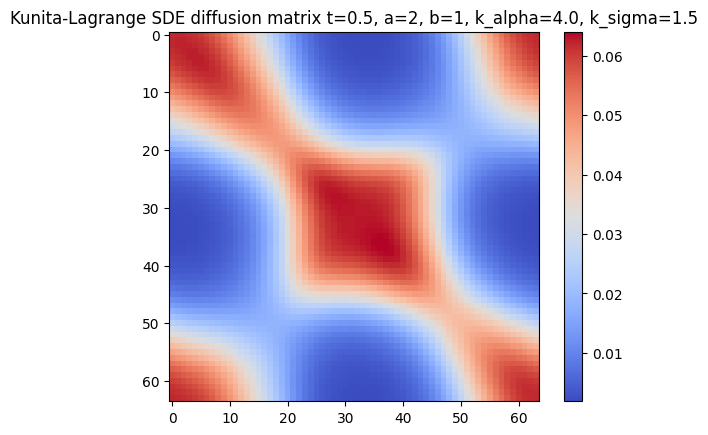

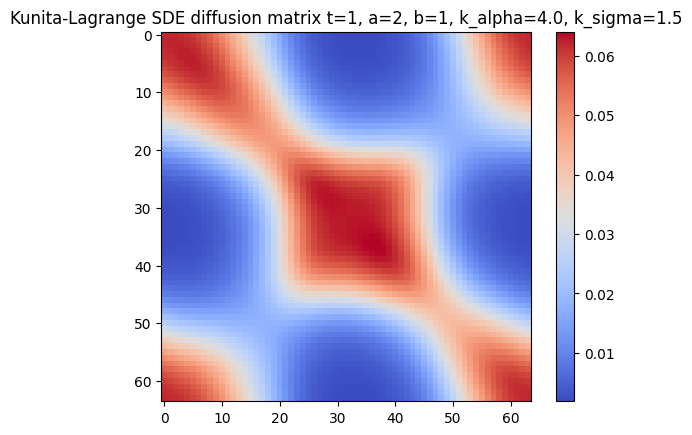

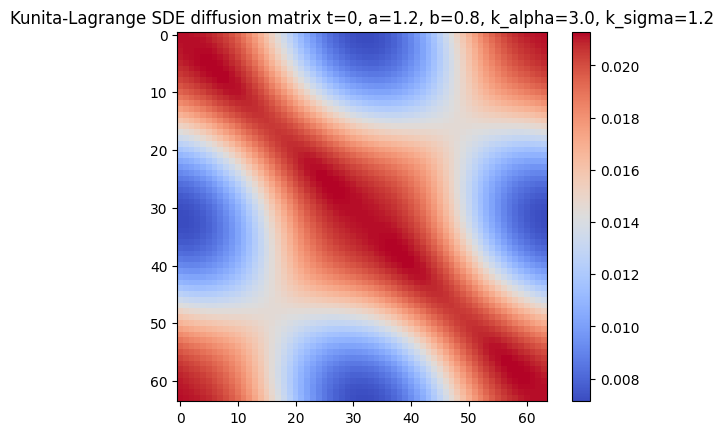

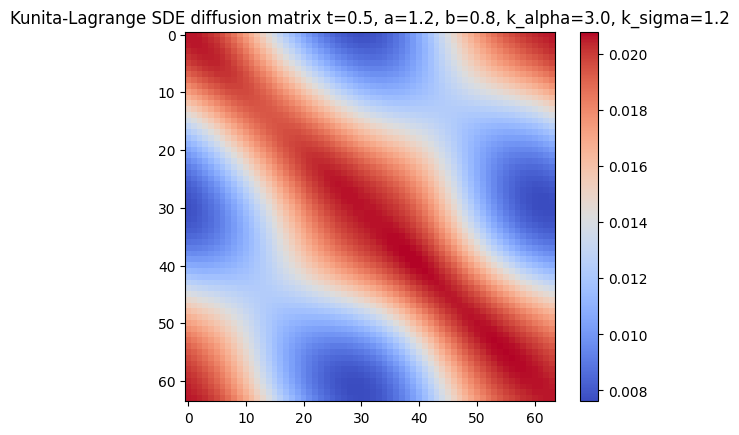

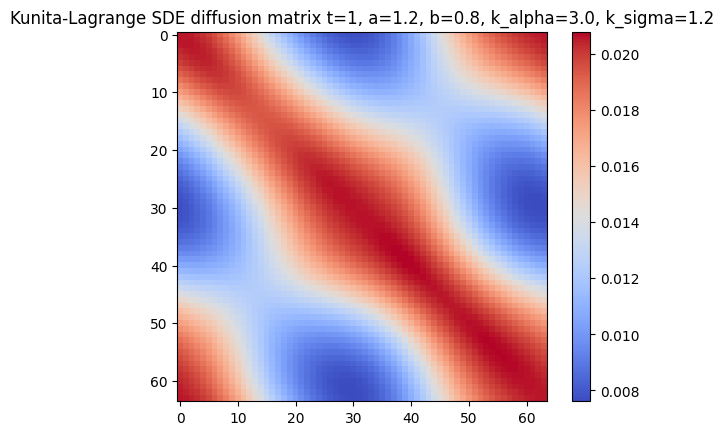

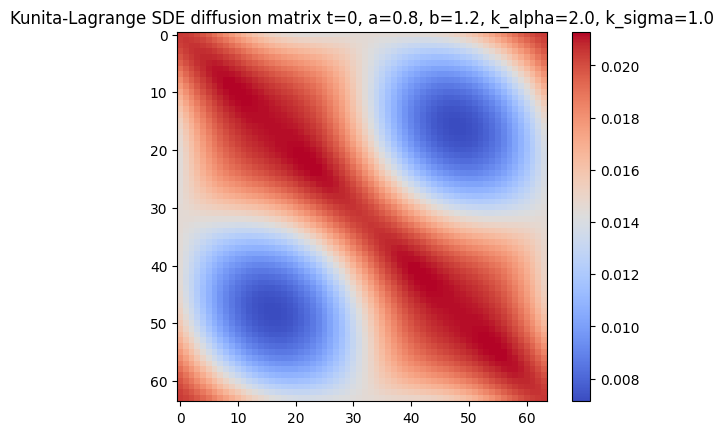

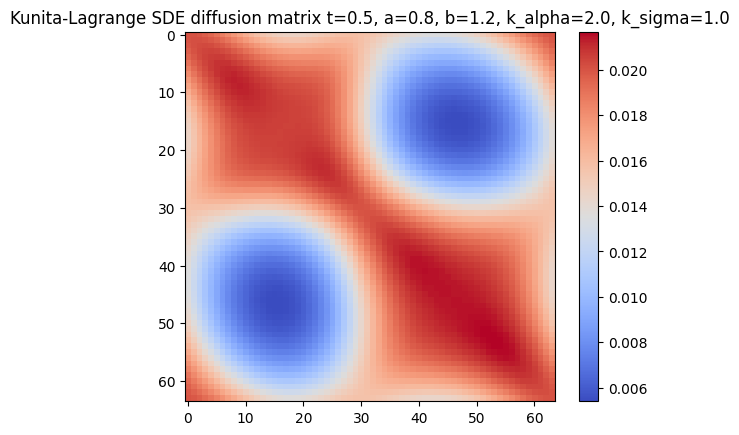

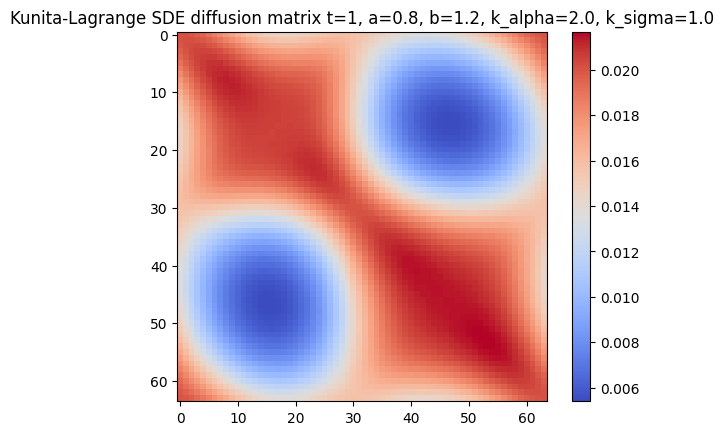

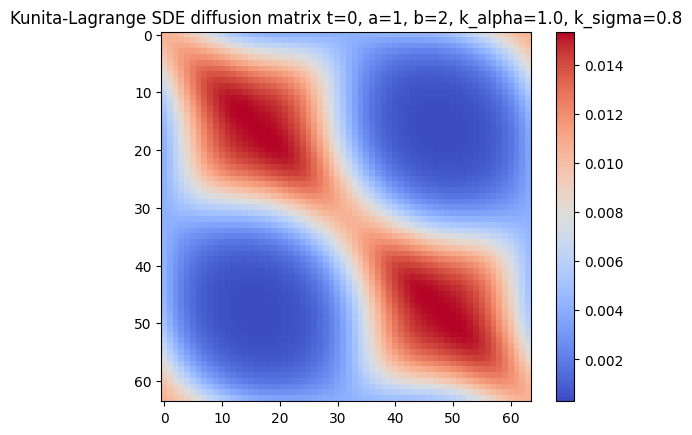

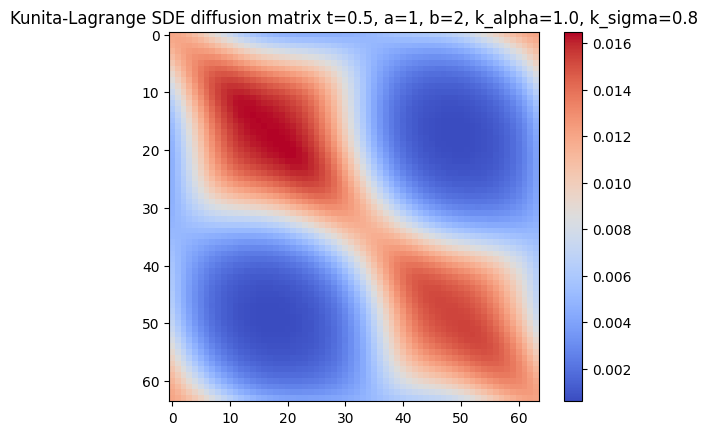

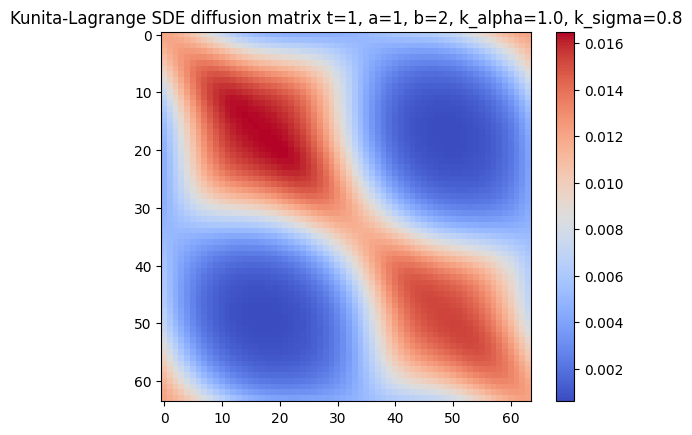

Bar desc:   0%|          | 0/3000 [00:00<?, ?it/s]

(51,)
(50, 8)


Training loss: 77.57604217529297: 100%|██████████| 3000/3000 [00:49<00:00, 60.27it/s]


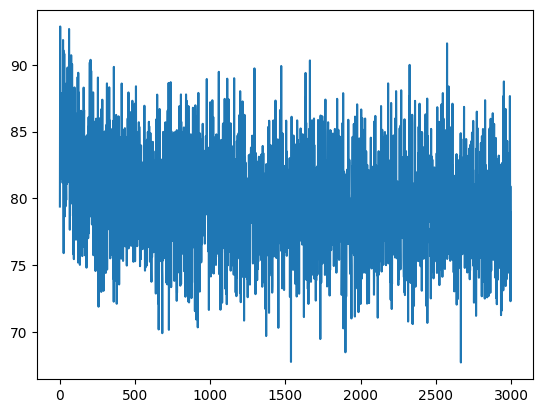

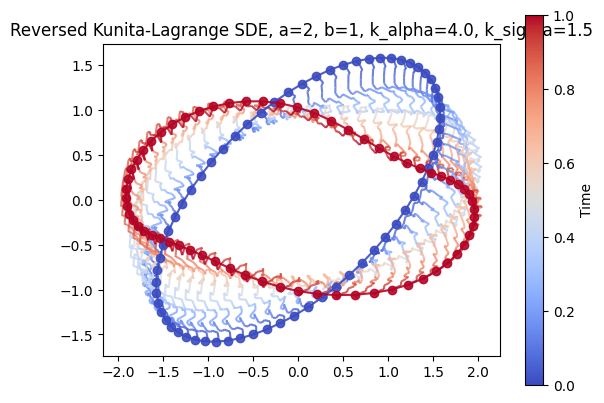

Bar desc:   0%|          | 0/3000 [00:00<?, ?it/s]

(51,)
(50, 8)


Training loss: 35.879756927490234: 100%|██████████| 3000/3000 [00:47<00:00, 62.52it/s]


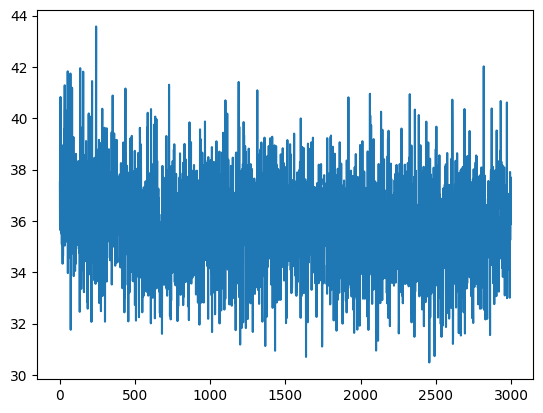

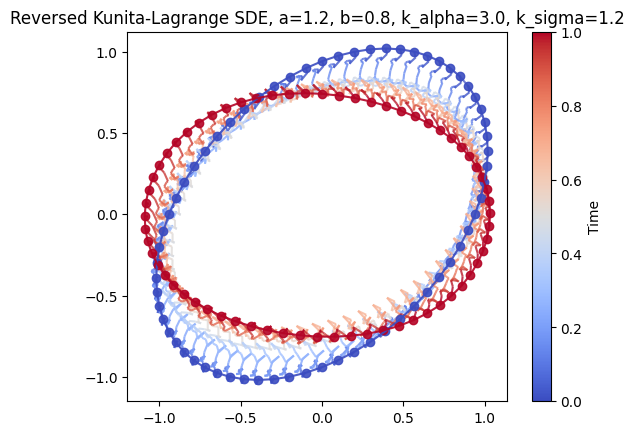

Bar desc:   0%|          | 0/3000 [00:00<?, ?it/s]

(51,)
(50, 8)


Training loss: 33.64725875854492: 100%|██████████| 3000/3000 [00:47<00:00, 62.74it/s] 


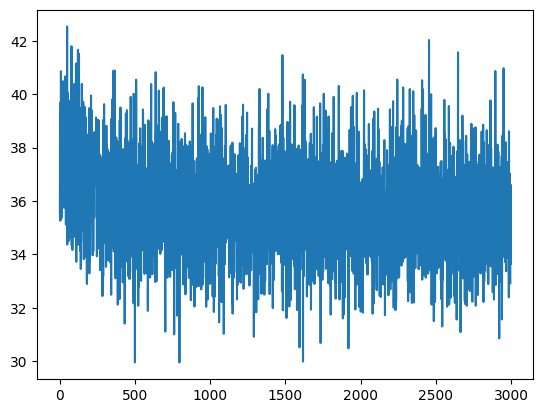

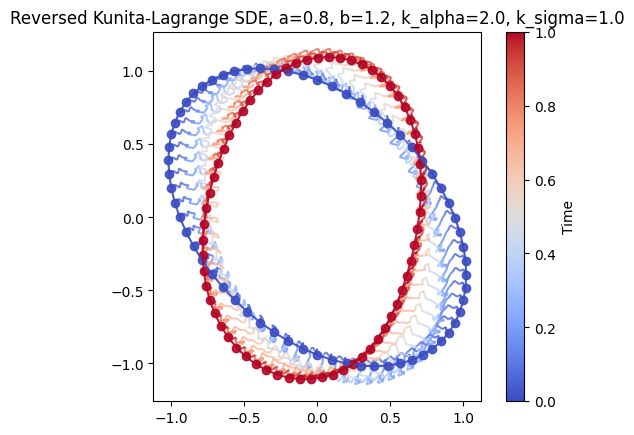

Bar desc:   0%|          | 0/3000 [00:00<?, ?it/s]

(51,)
(50, 8)


Training loss: 64.4141616821289: 100%|██████████| 3000/3000 [00:47<00:00, 62.80it/s]  


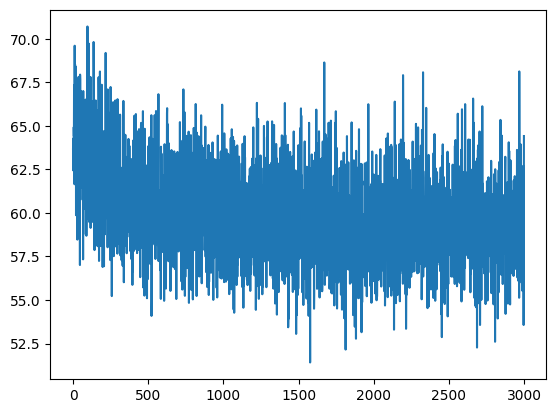

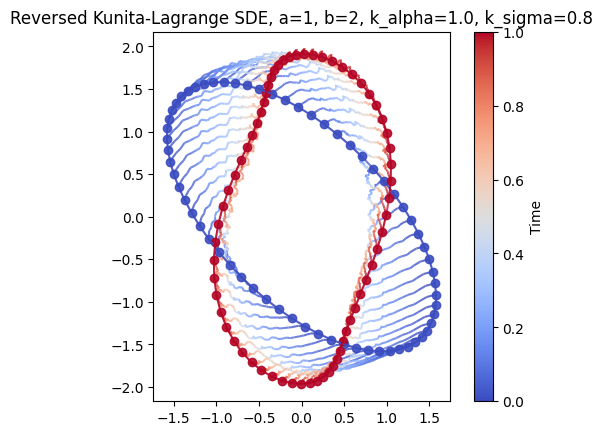

In [6]:
# example 3: learning the score function of a Kunita-Lagrange SDE
# circle_data_generator = ToyData.CircleDataGenerator(landmark_num=128, radius=0.5, center=jnp.array([0, 0]), seed=get_random_int())
# x_0 = circle_data_generator.generate_data(16)

lagrange_k_alpha_1 = ssm_config.lagrange_sde_configs['sde_params']['k_alpha'][0]
lagrange_k_alpha_2 = ssm_config.lagrange_sde_configs['sde_params']['k_alpha'][1]
lagrange_k_alpha_3 = ssm_config.lagrange_sde_configs['sde_params']['k_alpha'][2]
lagrange_k_alpha_4 = ssm_config.lagrange_sde_configs['sde_params']['k_alpha'][3]

lagrange_k_sigma_1 = ssm_config.lagrange_sde_configs['sde_params']['k_sigma'][0]
lagrange_k_sigma_2 = ssm_config.lagrange_sde_configs['sde_params']['k_sigma'][1]
lagrange_k_sigma_3 = ssm_config.lagrange_sde_configs['sde_params']['k_sigma'][2]
lagrange_k_sigma_4 = ssm_config.lagrange_sde_configs['sde_params']['k_sigma'][3]


kunita_lagrange_sde_1 = SDE.Kunita_Lagrange_SDE(sigma=lagrange_k_alpha_1 ,kappa=lagrange_k_sigma_1, x0=x_0_1[0])
kunita_lagrange_sde_2 = SDE.Kunita_Lagrange_SDE(sigma=2 ,kappa=1.5, x0=x_0_2[0])
kunita_lagrange_sde_3 = SDE.Kunita_Lagrange_SDE(sigma=2 ,kappa=1.5, x0=x_0_3[0])
kunita_lagrange_sde_4 = SDE.Kunita_Lagrange_SDE(sigma=2 ,kappa=1.5, x0=x_0_4[0])

kunita_lagrange_sde_solver_1 = SDESolver.EulerMaruyama.from_sde(kunita_lagrange_sde_1, 0.02, 1, 2)
kunita_lagrange_sde_solver_2 = SDESolver.EulerMaruyama.from_sde(kunita_lagrange_sde_2, 0.02, 1, 2)
kunita_lagrange_sde_solver_3 = SDESolver.EulerMaruyama.from_sde(kunita_lagrange_sde_3, 0.02, 1, 2)
kunita_lagrange_sde_solver_4 = SDESolver.EulerMaruyama.from_sde(kunita_lagrange_sde_4, 0.02, 1, 2)

xs_1, diffusions_1 = jax.vmap(kunita_lagrange_sde_solver_1.solve, in_axes=(0, None))(x_0_1, jrandom.PRNGKey(get_random_int()))
xs_2, diffusions_2 = jax.vmap(kunita_lagrange_sde_solver_2.solve, in_axes=(0, None))(x_0_2, jrandom.PRNGKey(get_random_int()))
xs_3, diffusions_3 = jax.vmap(kunita_lagrange_sde_solver_3.solve, in_axes=(0, None))(x_0_3, jrandom.PRNGKey(get_random_int()))
xs_4, diffusions_4 = jax.vmap(kunita_lagrange_sde_solver_4.solve, in_axes=(0, None))(x_0_4, jrandom.PRNGKey(get_random_int()))

plot_trajectory_2d(xs_1[0], "Kunita-Lagrange SDE, a="+str(a_1)+", b="+str(b_1)+", k_alpha="+str(lagrange_k_alpha_1)+", k_sigma="+str(lagrange_k_sigma_1), simplified=False)
plot_trajectory_2d(xs_2[0], "Kunita-Lagrange SDE, a="+str(a_2)+", b="+str(b_2)+", k_alpha="+str(lagrange_k_alpha_2)+", k_sigma="+str(lagrange_k_sigma_2), simplified=False)
plot_trajectory_2d(xs_3[0], "Kunita-Lagrange SDE, a="+str(a_3)+", b="+str(b_3)+", k_alpha="+str(lagrange_k_alpha_3)+", k_sigma="+str(lagrange_k_sigma_3), simplified=False)
plot_trajectory_2d(xs_4[0], "Kunita-Lagrange SDE, a="+str(a_4)+", b="+str(b_4)+", k_alpha="+str(lagrange_k_alpha_4)+", k_sigma="+str(lagrange_k_sigma_4), simplified=False)
plt.show()

plot_matrix(diffusions_1[0, 0] @ diffusions_1[0, 0].T, "Kunita-Lagrange SDE diffusion matrix t=0, a="+str(a_1)+", b="+str(b_1)+", k_alpha="+str(lagrange_k_alpha_1)+", k_sigma="+str(lagrange_k_sigma_1))
plot_matrix(diffusions_1[0,49] @ diffusions_1[0,49].T, "Kunita-Lagrange SDE diffusion matrix t=0.5, a="+str(a_1)+", b="+str(b_1)+", k_alpha="+str(lagrange_k_alpha_1)+", k_sigma="+str(lagrange_k_sigma_1))
plot_matrix(diffusions_1[0, -1] @ diffusions_1[0, -1].T, "Kunita-Lagrange SDE diffusion matrix t=1, a="+str(a_1)+", b="+str(b_1)+", k_alpha="+str(lagrange_k_alpha_1)+", k_sigma="+str(lagrange_k_sigma_1))
plt.show()

plot_matrix(diffusions_2[0, 0] @ diffusions_2[0, 0].T, "Kunita-Lagrange SDE diffusion matrix t=0, a="+str(a_2)+", b="+str(b_2)+", k_alpha="+str(lagrange_k_alpha_2)+", k_sigma="+str(lagrange_k_sigma_2))
plot_matrix(diffusions_2[0,49] @ diffusions_2[0,49].T, "Kunita-Lagrange SDE diffusion matrix t=0.5, a="+str(a_2)+", b="+str(b_2)+", k_alpha="+str(lagrange_k_alpha_2)+", k_sigma="+str(lagrange_k_sigma_2))
plot_matrix(diffusions_2[0, -1] @ diffusions_2[0, -1].T, "Kunita-Lagrange SDE diffusion matrix t=1, a="+str(a_2)+", b="+str(b_2)+", k_alpha="+str(lagrange_k_alpha_2)+", k_sigma="+str(lagrange_k_sigma_2))
plt.show()

plot_matrix(diffusions_3[0, 0] @ diffusions_3[0, 0].T, "Kunita-Lagrange SDE diffusion matrix t=0, a="+str(a_3)+", b="+str(b_3)+", k_alpha="+str(lagrange_k_alpha_3)+", k_sigma="+str(lagrange_k_sigma_3))
plot_matrix(diffusions_3[0,49] @ diffusions_3[0,49].T, "Kunita-Lagrange SDE diffusion matrix t=0.5, a="+str(a_3)+", b="+str(b_3)+", k_alpha="+str(lagrange_k_alpha_3)+", k_sigma="+str(lagrange_k_sigma_3))
plot_matrix(diffusions_3[0, -1] @ diffusions_3[0, -1].T, "Kunita-Lagrange SDE diffusion matrix t=1, a="+str(a_3)+", b="+str(b_3)+", k_alpha="+str(lagrange_k_alpha_3)+", k_sigma="+str(lagrange_k_sigma_3))
plt.show()

plot_matrix(diffusions_4[0, 0] @ diffusions_4[0, 0].T, "Kunita-Lagrange SDE diffusion matrix t=0, a="+str(a_4)+", b="+str(b_4)+", k_alpha="+str(lagrange_k_alpha_4)+", k_sigma="+str(lagrange_k_sigma_4))
plot_matrix(diffusions_4[0,49] @ diffusions_4[0,49].T, "Kunita-Lagrange SDE diffusion matrix t=0.5, a="+str(a_4)+", b="+str(b_4)+", k_alpha="+str(lagrange_k_alpha_4)+", k_sigma="+str(lagrange_k_sigma_4))
plot_matrix(diffusions_4[0, -1] @ diffusions_4[0, -1].T, "Kunita-Lagrange SDE diffusion matrix t=1, a="+str(a_4)+", b="+str(b_4)+", k_alpha="+str(lagrange_k_alpha_4)+", k_sigma="+str(lagrange_k_sigma_4))
plt.show()




model = models.DsmModel(dim=2, score_hidden_dims=(128, 512, 128), x_hidden_dims=(128, 512, 128), t_hidden_dims=(128, 512, 128), with_x0=True, t_embedding_dim=80)
trainer = Trainer.SsmTrainer(seed=get_random_int())
train_state_1 = trainer.train_state_init(model, lr=1e-4, model_kwargs={'x': x_0_1[0], 't': jnp.array([0]), 'x0': x_0_1[0]})
train_state_1, losses_1 = trainer.train(train_state_1, kunita_lagrange_sde_1, kunita_lagrange_sde_solver_1, ellipse_data_generator_1, 3000, 8)
plt.plot(losses_1)
plt.show()
score_fn_1 = lambda x, t, x0: train_state_1.apply_fn(train_state_1.params, x, t, x0=x0)
ellipse_data_generator_test_1 = ToyData.EllipseDataGenerator(landmark_num=64, a=a_1, b=b_1, rotation_matrix=rotation_matrix_2, center=center_1, seed=get_random_int())
xt_1 = ellipse_data_generator_test_1.generate_data(1)
reversed_sde_1 = SDE.Time_Reversed_SDE(kunita_lagrange_sde_1, score_fn_1, 1, 0.02)
reversed_sde_solver_1 = SDESolver.EulerMaruyama.from_sde(reversed_sde_1, 0.02, 1, 2, condition_x=x_0_1[0])
xs_1, _ = reversed_sde_solver_1.solve(xt_1[0], jrandom.PRNGKey(get_random_int()))
plot_trajectory_2d(xs_1, "Reversed Kunita-Lagrange SDE, a="+str(a_1)+", b="+str(b_1)+", k_alpha="+str(lagrange_k_alpha_1)+", k_sigma="+str(lagrange_k_sigma_1), simplified=False)
plt.show()

train_state_2 = trainer.train_state_init(model, lr=1e-4, model_kwargs={'x': x_0_2[0], 't': jnp.array([0]), 'x0': x_0_2[0]})
train_state_2, losses_2 = trainer.train(train_state_2, kunita_lagrange_sde_2, kunita_lagrange_sde_solver_2, ellipse_data_generator_2, 3000, 8)
plt.plot(losses_2)
plt.show()
score_fn_2 = lambda x, t, x0: train_state_2.apply_fn(train_state_2.params, x, t, x0=x0)
ellipse_data_generator_test_2 = ToyData.EllipseDataGenerator(landmark_num=64, a=a_2, b=b_2, rotation_matrix=rotation_matrix_2, center=center_2, seed=get_random_int())
xt_2 = ellipse_data_generator_test_2.generate_data(1)
reversed_sde_2 = SDE.Time_Reversed_SDE(kunita_lagrange_sde_2, score_fn_2, 1, 0.02)
reversed_sde_solver_2 = SDESolver.EulerMaruyama.from_sde(reversed_sde_2, 0.02, 1, 2, condition_x=x_0_2[0])
xs_2, _ = reversed_sde_solver_2.solve(xt_2[0], jrandom.PRNGKey(get_random_int()))
plot_trajectory_2d(xs_2, "Reversed Kunita-Lagrange SDE, a="+str(a_2)+", b="+str(b_2)+", k_alpha="+str(lagrange_k_alpha_2)+", k_sigma="+str(lagrange_k_sigma_2), simplified=False)
plt.show()

train_state_3 = trainer.train_state_init(model, lr=1e-4, model_kwargs={'x': x_0_3[0], 't': jnp.array([0]), 'x0': x_0_3[0]})
train_state_3, losses_3 = trainer.train(train_state_3, kunita_lagrange_sde_3, kunita_lagrange_sde_solver_3, ellipse_data_generator_3, 3000, 8)
plt.plot(losses_3)
plt.show()
score_fn_3 = lambda x, t, x0: train_state_3.apply_fn(train_state_3.params, x, t, x0=x0)
ellipse_data_generator_test_3 = ToyData.EllipseDataGenerator(landmark_num=64, a=a_3, b=b_3, rotation_matrix=rotation_matrix_2, center=center_3, seed=get_random_int())
xt_3 = ellipse_data_generator_test_3.generate_data(1)
reversed_sde_3 = SDE.Time_Reversed_SDE(kunita_lagrange_sde_3, score_fn_3, 1, 0.02)
reversed_sde_solver_3 = SDESolver.EulerMaruyama.from_sde(reversed_sde_3, 0.02, 1, 2, condition_x=x_0_3[0])
xs_3, _ = reversed_sde_solver_3.solve(xt_3[0], jrandom.PRNGKey(get_random_int()))
plot_trajectory_2d(xs_3, "Reversed Kunita-Lagrange SDE, a="+str(a_3)+", b="+str(b_3)+", k_alpha="+str(lagrange_k_alpha_3)+", k_sigma="+str(lagrange_k_sigma_3), simplified=False)
plt.show()


train_state_4 = trainer.train_state_init(model, lr=1e-4, model_kwargs={'x': x_0_4[0], 't': jnp.array([0]), 'x0': x_0_4[0]})
train_state_4, losses_4 = trainer.train(train_state_4, kunita_lagrange_sde_4, kunita_lagrange_sde_solver_4, ellipse_data_generator_4, 3000, 8)
plt.plot(losses_4)
plt.show()
score_fn_4 = lambda x, t, x0: train_state_4.apply_fn(train_state_4.params, x, t, x0=x0)
ellipse_data_generator_test_4 = ToyData.EllipseDataGenerator(landmark_num=64, a=a_4, b=b_4, rotation_matrix=rotation_matrix_2, center=center_4, seed=get_random_int())
xt_4 = ellipse_data_generator_test_4.generate_data(1)
reversed_sde_4 = SDE.Time_Reversed_SDE(kunita_lagrange_sde_4, score_fn_4, 1, 0.02)
reversed_sde_solver_4 = SDESolver.EulerMaruyama.from_sde(reversed_sde_4, 0.02, 1, 2, condition_x=x_0_4[0])
xs_4, _ = reversed_sde_solver_4.solve(xt_4[0], jrandom.PRNGKey(get_random_int()))
plot_trajectory_2d(xs_4, "Reversed Kunita-Lagrange SDE, a="+str(a_4)+", b="+str(b_4)+", k_alpha="+str(lagrange_k_alpha_4)+", k_sigma="+str(lagrange_k_sigma_4), simplified=False)
plt.show()



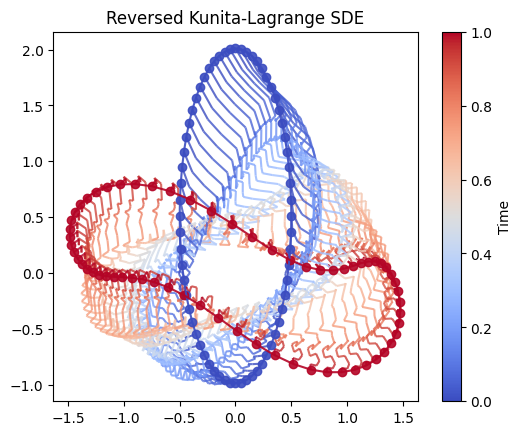

In [7]:

import src.math.geometry as geometry
theta = jnp.pi/2
rotation_matrix = geometry.get_rotation_matrix(theta)
ellipse_data_generator = ToyData.EllipseDataGenerator(landmark_num=64, a=1.5, b=0.5, rotation_matrix=rotation_matrix, center=jnp.array([0.51, 0]), seed=get_random_int())
xt = ellipse_data_generator.generate_data(1)
reversed_sde = SDE.Time_Reversed_SDE(kunita_lagrange_sde_1, score_fn_1, 1, 0.02)
reversed_sde_solver = SDESolver.EulerMaruyama.from_sde(reversed_sde, 0.02, 1, 2, condition_x=x_0_1[0])
xs, _ = reversed_sde_solver.solve(xt[0], jrandom.PRNGKey(get_random_int()))
plot_trajectory_2d(xs, "Reversed Kunita-Lagrange SDE", simplified=False)
